<a href="https://colab.research.google.com/github/kimhyunji24/ComputerNetwork_Project/blob/main/Personal_Project_code_%26_report_202121620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


필요한 라이브러리 import

In [ ]:
!pip install category_encoders
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re

import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings(action='ignore')
import csv

In [ ]:
import random, os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정을 위함

## Data set Load & Check

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/DA_contest/data_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DA_contest/data_test.csv')

train data set 확인

In [ ]:
train_data

temperature.avg.  temperature.min.  temperature.max.  wind speed.max.  \
0                 -7.6             -11.1              -3.8              5.3   
1                 17.8              12.5              23.0              6.4   
2                  8.4               6.2               9.9              3.5   
3                 10.8               4.7              17.4              5.8   
4                 15.1               9.8              21.4              6.7   
...                ...               ...               ...              ...   
2551              29.3              26.4              32.6              4.5   
2552              22.0              17.6              28.4              5.6   
2553              25.9              24.6              28.2              6.8   
2554              25.1              20.1              29.6              2.8   
2555              -5.8              -9.6              -1.8              5.2   

      wind direction.max.  wind speed.avg.  dew point.avg.  humidity.avg.  \
0                   340.0              2.6           -19.2           40.5   
1                    50.0              3.2             2.0           35.6   
2                   200.0              1.5             5.4           82.1   
3                   200.0              2.8             4.5           66.6   
4                   270.0              3.0             4.9           55.1   
...                   ...              ...             ...            ...   
2551                340.0              1.8            23.5           71.8   
2552                290.0              2.4            16.6           73.3   
2553                250.0              4.4            22.7           83.9   
2554                140.0              1.5            15.3           55.8   
2555                290.0              2.7           -17.5           40.8   

      atmospheric pressure.avg.  insolation time.sum.  insolation.sum.  \
0                        1021.1                   6.2             7.62   
1                        1008.7                   3.4            15.37   
2                        1003.1                   0.0             3.51   
3                         999.2                   9.7            15.34   
4                        1005.1                  10.8            19.82   
...                         ...                   ...              ...   
2551                      995.3                   3.6            14.90   
2552                      993.9                   9.5            24.64   
2553                      996.6                   0.0              NaN   
2554                      999.2                   9.2            20.34   
2555                     1011.0                   8.7            13.74   

      cloud.avg.  ground temperature.avg  1.0m temperature.avg  \
0            5.4                    -4.1                   5.4   
1            8.1                    15.3                  10.5   
2            8.0                    10.2                  12.6   
3            0.8                     5.5                   4.7   
4            3.9                    21.8                  13.2   
...          ...                     ...                   ...   
2551         6.9                    30.8                  23.0   
2552         5.8                    27.1                  18.4   
2553         9.8                    27.1                  24.4   
2554         5.5                    28.4                  25.6   
2555         4.1                    -3.2                   3.1   

      5.0m temperature.avg  weather label  
0                     16.3              0  
1                     13.8              1  
2                     13.0              1  
3                     15.3              0  
4                     13.6              0  
...                    ...            ...  
2551                  14.9              1  
2552                  13.5              0  
2553                  15.1              1  
2554      

In [ ]:
# 훈련 세트와 테스트 세트의 크기 확인
print("훈련 세트 크기:", len(train_data))
print("테스트 세트 크기:", len(test_data))

훈련 세트 크기: 2556
테스트 세트 크기: 1096


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temperature.avg.           2556 non-null   float64
 1   temperature.min.           2555 non-null   float64
 2   temperature.max.           2556 non-null   float64
 3   wind speed.max.            2555 non-null   float64
 4   wind direction.max.        2555 non-null   float64
 5   wind speed.avg.            2554 non-null   float64
 6   dew point.avg.             2556 non-null   float64
 7   humidity.avg.              2556 non-null   float64
 8   atmospheric pressure.avg.  2555 non-null   float64
 9   insolation time.sum.       2546 non-null   float64
 10  insolation.sum.            2535 non-null   float64
 11  cloud.avg.                 2556 non-null   float64
 12  ground temperature.avg     2555 non-null   float64
 13  1.0m temperature.avg       2550 non-null   float

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#미리보기 시, 안잘리고 모든 값을 확인할 수 있도록 조정

In [ ]:
# 결측치 확인
print("\nTrain Data Missing Values:")
print(train_data.isnull().sum())
print("\nTest Data Missing Values:")
print(test_data.isnull().sum())



Train Data Missing Values:
temperature.avg.              0
temperature.min.              1
temperature.max.              0
wind speed.max.               1
wind direction.max.           1
wind speed.avg.               2
dew point.avg.                0
humidity.avg.                 0
atmospheric pressure.avg.     1
insolation time.sum.         10
insolation.sum.              21
cloud.avg.                    0
ground temperature.avg        1
1.0m temperature.avg          6
5.0m temperature.avg          3
weather label                 0
dtype: int64

Test Data Missing Values:
temperature.avg.             0
temperature.min.             0
temperature.max.             1
wind speed.max.              1
wind direction.max.          1
wind speed.avg.              1
dew point.avg.               0
humidity.avg.                0
atmospheric pressure.avg.    0
insolation time.sum.         2
insolation.sum.              4
cloud.avg.                   0
ground temperature.avg       0
1.0m temperature.

train, test 결측치 존재.

In [ ]:
train_data

temperature.avg.  temperature.min.  temperature.max.  wind speed.max.  \
0                 -7.6             -11.1              -3.8              5.3   
1                 17.8              12.5              23.0              6.4   
2                  8.4               6.2               9.9              3.5   
3                 10.8               4.7              17.4              5.8   
4                 15.1               9.8              21.4              6.7   
5                  9.5               4.3              15.7              4.7   
6                 20.1              16.1              26.0              5.1   
7                 13.1               7.8              18.5              7.2   
8                 -2.9              -8.0               1.6              6.1   
9                 27.5              24.0              31.9              3.6   
10                 7.9               1.6              15.1              2.7   
11                 9.4               4.6              14.5              5.3   
12                23.7              20.4              26.5              1.6   
13                23.8              19.7              29.5              5.2   
14                24.7              22.3              29.0              3.8   
15                13.5               7.7              20.4              4.9   
16                 7.9               0.1              15.4              2.9   
17                -1.6              -5.9               4.0              3.4   
18                13.2               8.6              18.9              3.9   
19                15.9              12.0              23.0              6.4   
20                -6.4              -8.9              -3.1              7.6   
21                12.1               8.9              16.1              2.8   
22                20.0              14.7              25.9              3.9   
23                 1.8               1.0               3.8              4.8   
24                12.6               9.2              17.6              3.8   
25                 2.8              -2.7               8.7              3.9   
26                18.7              12.9              24.4              3.8   
27                13.6               8.2              20.6              3.4   
28                 6.9               5.8               8.0              4.8   
29                21.0              14.8              27.5              5.4   
30                14.8               8.4              19.7              5.2   
31                 4.5               1.2               9.1              4.3   
32                10.0               3.4              16.7              3.3   
33                13.4               9.8              18.1              4.0   
34                28.7              24.2              32.8              4.8   
35                 2.1              -2.4               5.8              7.0   
36                 2.5               1.0               3.9              4.7   
37                18.6              12.3              25.9              5.4   
38                23.0              18.1              29.0              3.7   
39                -1.3              -3.0               1.5              7.2   
40                23.4              17.6              30.1              4.5   
41                22.6              17.9              28.6              4.0   
42                 6.0               4.1               8.3              6.4   
43                 7.4               3.7              11.5              5.9   
44                25.5              21.3              30.4              3.7   
45                 0.7              -3.5               4.6              3.8   
46                -2.6              -5.2               0.0              3.4   
47                16.2              12.1              21.3              4.6   
48                21.0              16.7              26.7              5.0   
49                15.9               9.2              23

In [ ]:
drop_x = ["weather label"] #예측할 label 제거
target = 'weather label'

train_data = train_data.astype(float)
test = test_data.astype(float)
train_data = train_data.dropna() #NaN data

#.dropna() ~ 결측치 아예 제거

# 중복 데이터 제거
before_train_size = train_data.shape[0]
train = train_data.drop_duplicates()
print(f'중복 데이터 제거 개수 : {before_train_size - train.shape[0]}')
train.reset_index(drop=True, inplace=True)

## => 중복 데이터 X



중복 데이터 제거 개수 : 0


In [ ]:
import statsmodels.api as sm

# 독립변수 : weather label 제외 모두
x = train_data[['temperature.avg.', 'temperature.min.',
'temperature.max.',
'wind speed.max.',
'wind direction.max.',
'wind speed.avg.',
'dew point.avg.',
'humidity.avg.',
'atmospheric pressure.avg.',
'insolation time.sum.',
'insolation.sum.',
'cloud.avg.',
'ground temperature.avg',
'1.0m temperature.avg',
'5.0m temperature.avg']]

# 종속변수 : weather label
y = train_data['weather label']

#절편 추가
X = sm.add_constant(x)

#모형 학습
model = sm.OLS(y,X).fit()

#예측치 생성
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          weather label   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     79.85
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          1.22e-199
Time:                        14:12:19   Log-Likelihood:                -2593.9
No. Observations:                2523   AIC:                             5220.
Df Residuals:                    2507   BIC:                             5313.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        18.7698      3.581      5.241      0.000      11.748      25.792
temperature.avg.              0.1192      0.033      3.582      0.000       0.054       0.185
temperature.min.             -0.0383      0.015     -2.497      0.013      -0.068      -0.008
temperature.max.             -0.0641      0.016     -4.111      0.000      -0.095      -0.033
wind speed.max.               0.1043      0.020      5.324      0.000       0.066       0.143
wind direction.max.         6.24e-05      0.000      0.355      0.722      -0.000       0.000
wind speed.avg.              -0.0999      0.035     -2.831      0.005      -0.169      -0.031
dew point.avg.               -0.1002      0.023     -4.284      0.000      -0.146      -0.054
humidity.avg.                 0.0403      0.006      6.508      0.000       0.028       0.052
atmospheric pressure.avg.    -0.0220      0.004     -6.289      0.000      -0.029      -0.015
insolation time.sum.         -0.0114      0.011     -1.033      0.302      -0.033       0.010
insolation.sum.               0.0044      0.006      0.725      0.469      -0.007       0.016
cloud.avg.                    0.0706      0.010      7.257      0.000       0.052       0.090
ground temperature.avg        0.0402      0.009      4.445      0.000       0.022       0.058
1.0m temperature.avg         -0.0015      0.007     -0.217      0.828      -0.015       0.012
5.0m temperature.avg          0.0454      0.016      2.908      0.004       0.015       0.076
==============================================================================
Omnibus:                     1361.619   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10594.723
Skew:                           2.472   Prob(JB):                         0.00
Kurtosis:                      11.737   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<Axes: xlabel='temperature.avg.', ylabel='temperature.avg.'>,
        <Axes: xlabel='temperature.min.', ylabel='temperature.avg.'>,
        <Axes: xlabel='temperature.max.', ylabel='temperature.avg.'>,
        <Axes: xlabel='wind speed.max.', ylabel='temperature.avg.'>,
        <Axes: xlabel='wind direction.max.', ylabel='temperature.avg.'>,
        <Axes: xlabel='wind speed.avg.', ylabel='temperature.avg.'>,
        <Axes: xlabel='dew point.avg.', ylabel='temperature.avg.'>,
        <Axes: xlabel='humidity.avg.', ylabel='temperature.avg.'>,
        <Axes: xlabel='atmospheric pressure.avg.', ylabel='temperature.avg.'>,
        <Axes: xlabel='insolation time.sum.', ylabel='temperature.avg.'>,
        <Axes: xlabel='insolation.sum.', ylabel='temperature.avg.'>,
        <Axes: xlabel='cloud.avg.', ylabel='temperature.avg.'>,
        <Axes: xlabel='ground temperature.avg', ylabel='temperature.avg.'>,
        <Axes: xlabel='1.0m temperature.avg', ylabel='temperature.avg.'>,
        

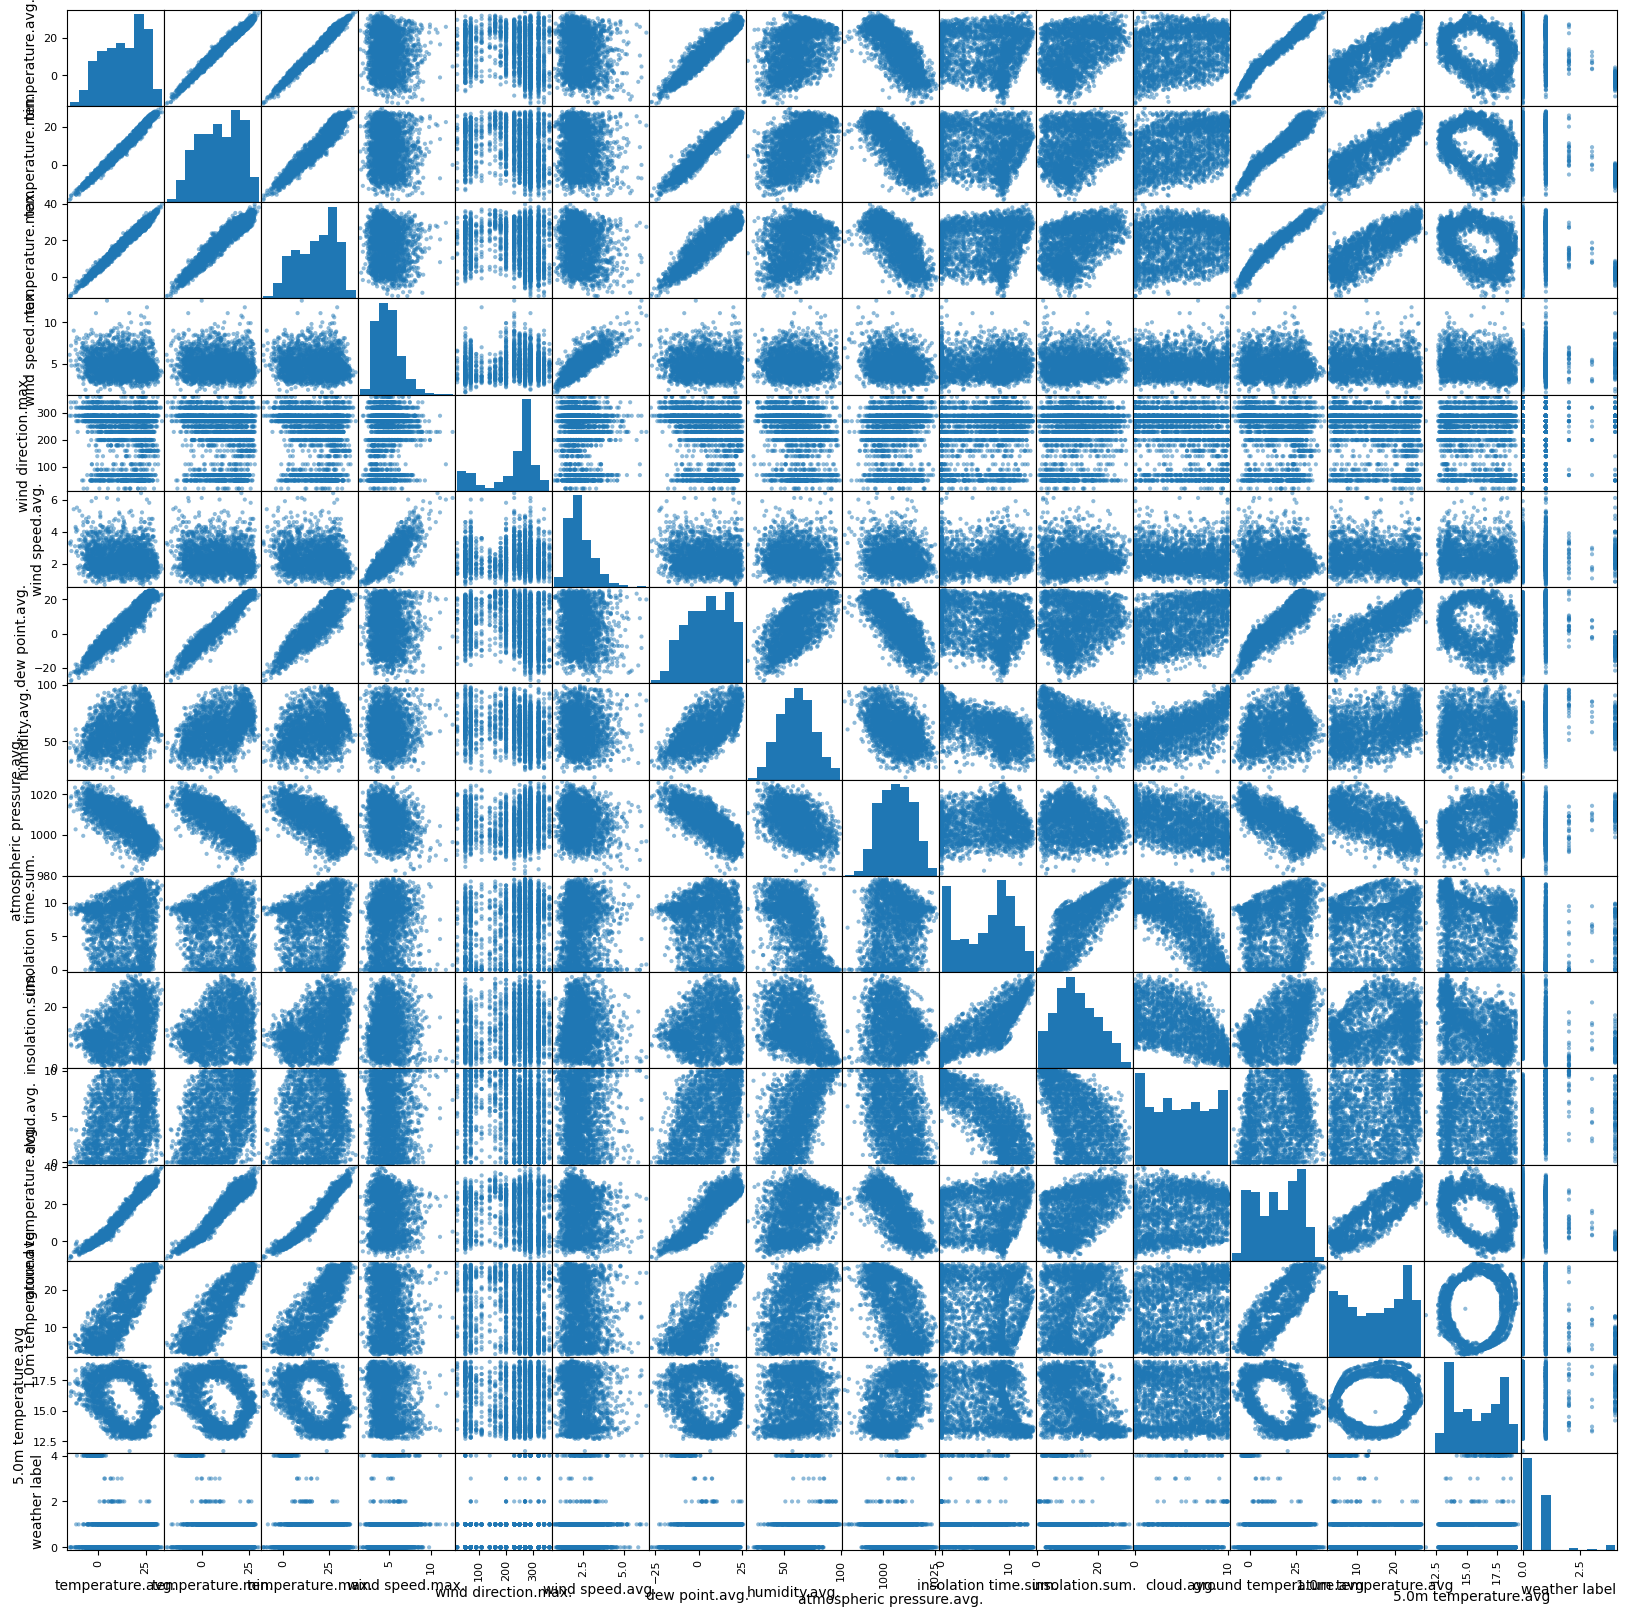

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_data, figsize = (20, 20))

마지막행으로 weather label과의 상관관계를 확인할 수 있음.

In [ ]:
#피어슨 상관계수
train_data.corr(method='pearson')

temperature.avg.  temperature.min.  \
temperature.avg.                   1.000000          0.989409   
temperature.min.                   0.989409          1.000000   
temperature.max.                   0.988738          0.961110   
wind speed.max.                   -0.091483         -0.078709   
wind direction.max.               -0.172465         -0.184603   
wind speed.avg.                   -0.137422         -0.109384   
dew point.avg.                     0.953087          0.968674   
humidity.avg.                      0.399437          0.471218   
atmospheric pressure.avg.         -0.768628         -0.788393   
insolation time.sum.              -0.013288         -0.104029   
insolation.sum.                    0.385164          0.301242   
cloud.avg.                         0.319091          0.390740   
ground temperature.avg             0.979139          0.963381   
1.0m temperature.avg               0.877589          0.884664   
5.0m temperature.avg              -0.279274         -0.259288   
weather label                     -0.120283         -0.070915   

                           temperature.max.  wind speed.max.  \
temperature.avg.                   0.988738        -0.091483   
temperature.min.                   0.961110        -0.078709   
temperature.max.                   1.000000        -0.098027   
wind speed.max.                   -0.098027         1.000000   
wind direction.max.               -0.145721         0.133229   
wind speed.avg.                   -0.161053         0.833887   
dew point.avg.                     0.916534        -0.094278   
humidity.avg.                      0.316915        -0.043893   
atmospheric pressure.avg.         -0.732056        -0.187092   
insolation time.sum.               0.090224         0.052509   
insolation.sum.                    0.470281         0.053832   
cloud.avg.                         0.227698        -0.032199   
ground temperature.avg             0.976583        -0.045657   
1.0m temperature.avg               0.850993        -0.123069   
5.0m temperature.avg              -0.298294        -0.218068   
weather label                     -0.176524         0.166091   

                           wind direction.max.  wind speed.avg.  \
temperature.avg.                     -0.172465        -0.137422   
temperature.min.                     -0.184603        -0.109384   
temperature.max.                     -0.145721        -0.161053   
wind speed.max.                       0.133229         0.833887   
wind direction.max.                   1.000000        -0.038580   
wind speed.avg.                      -0.038580         1.000000   
dew point.avg.                       -0.210608        -0.127239   
humidity.avg.                        -0.212243        -0.036723   
atmospheric pressure.avg.             0.082105        -0.139573   
insolation time.sum.                  0.289162         0.006248   
insolation.sum.                       0.174698         0.006936   
cloud.avg.                           -0.311208         0.002303   
ground temperature.avg               -0.111763        -0.092385   
1.0m temperature.avg                 -0.162365        -0.124758   
5.0m temperature.avg                 -0.070891        -0.132072   
weather label                        -0.043011         0.153813   

                           dew point.avg.  humidity.avg.  \
temperature.avg.                 0.953087       0.399437   
temperature.min.                 0.968674       0.471218   
temperature.max.                 0.916534       0.316915   
wind speed.max.                 -0.094278      -0.043893   
wind direction.max.             -0.210608      -0.212243   
wind speed.avg.                 -0.127239      -0.036723   
dew point.avg.                   1.000000       0.654155   
humidity.avg.                    0.654155       1.000000   
atmospheric pressure.avg.       -0.785844      -0.480838   
insolation time.sum.            -0.210922      -0.619368   
insolation.sum.                 

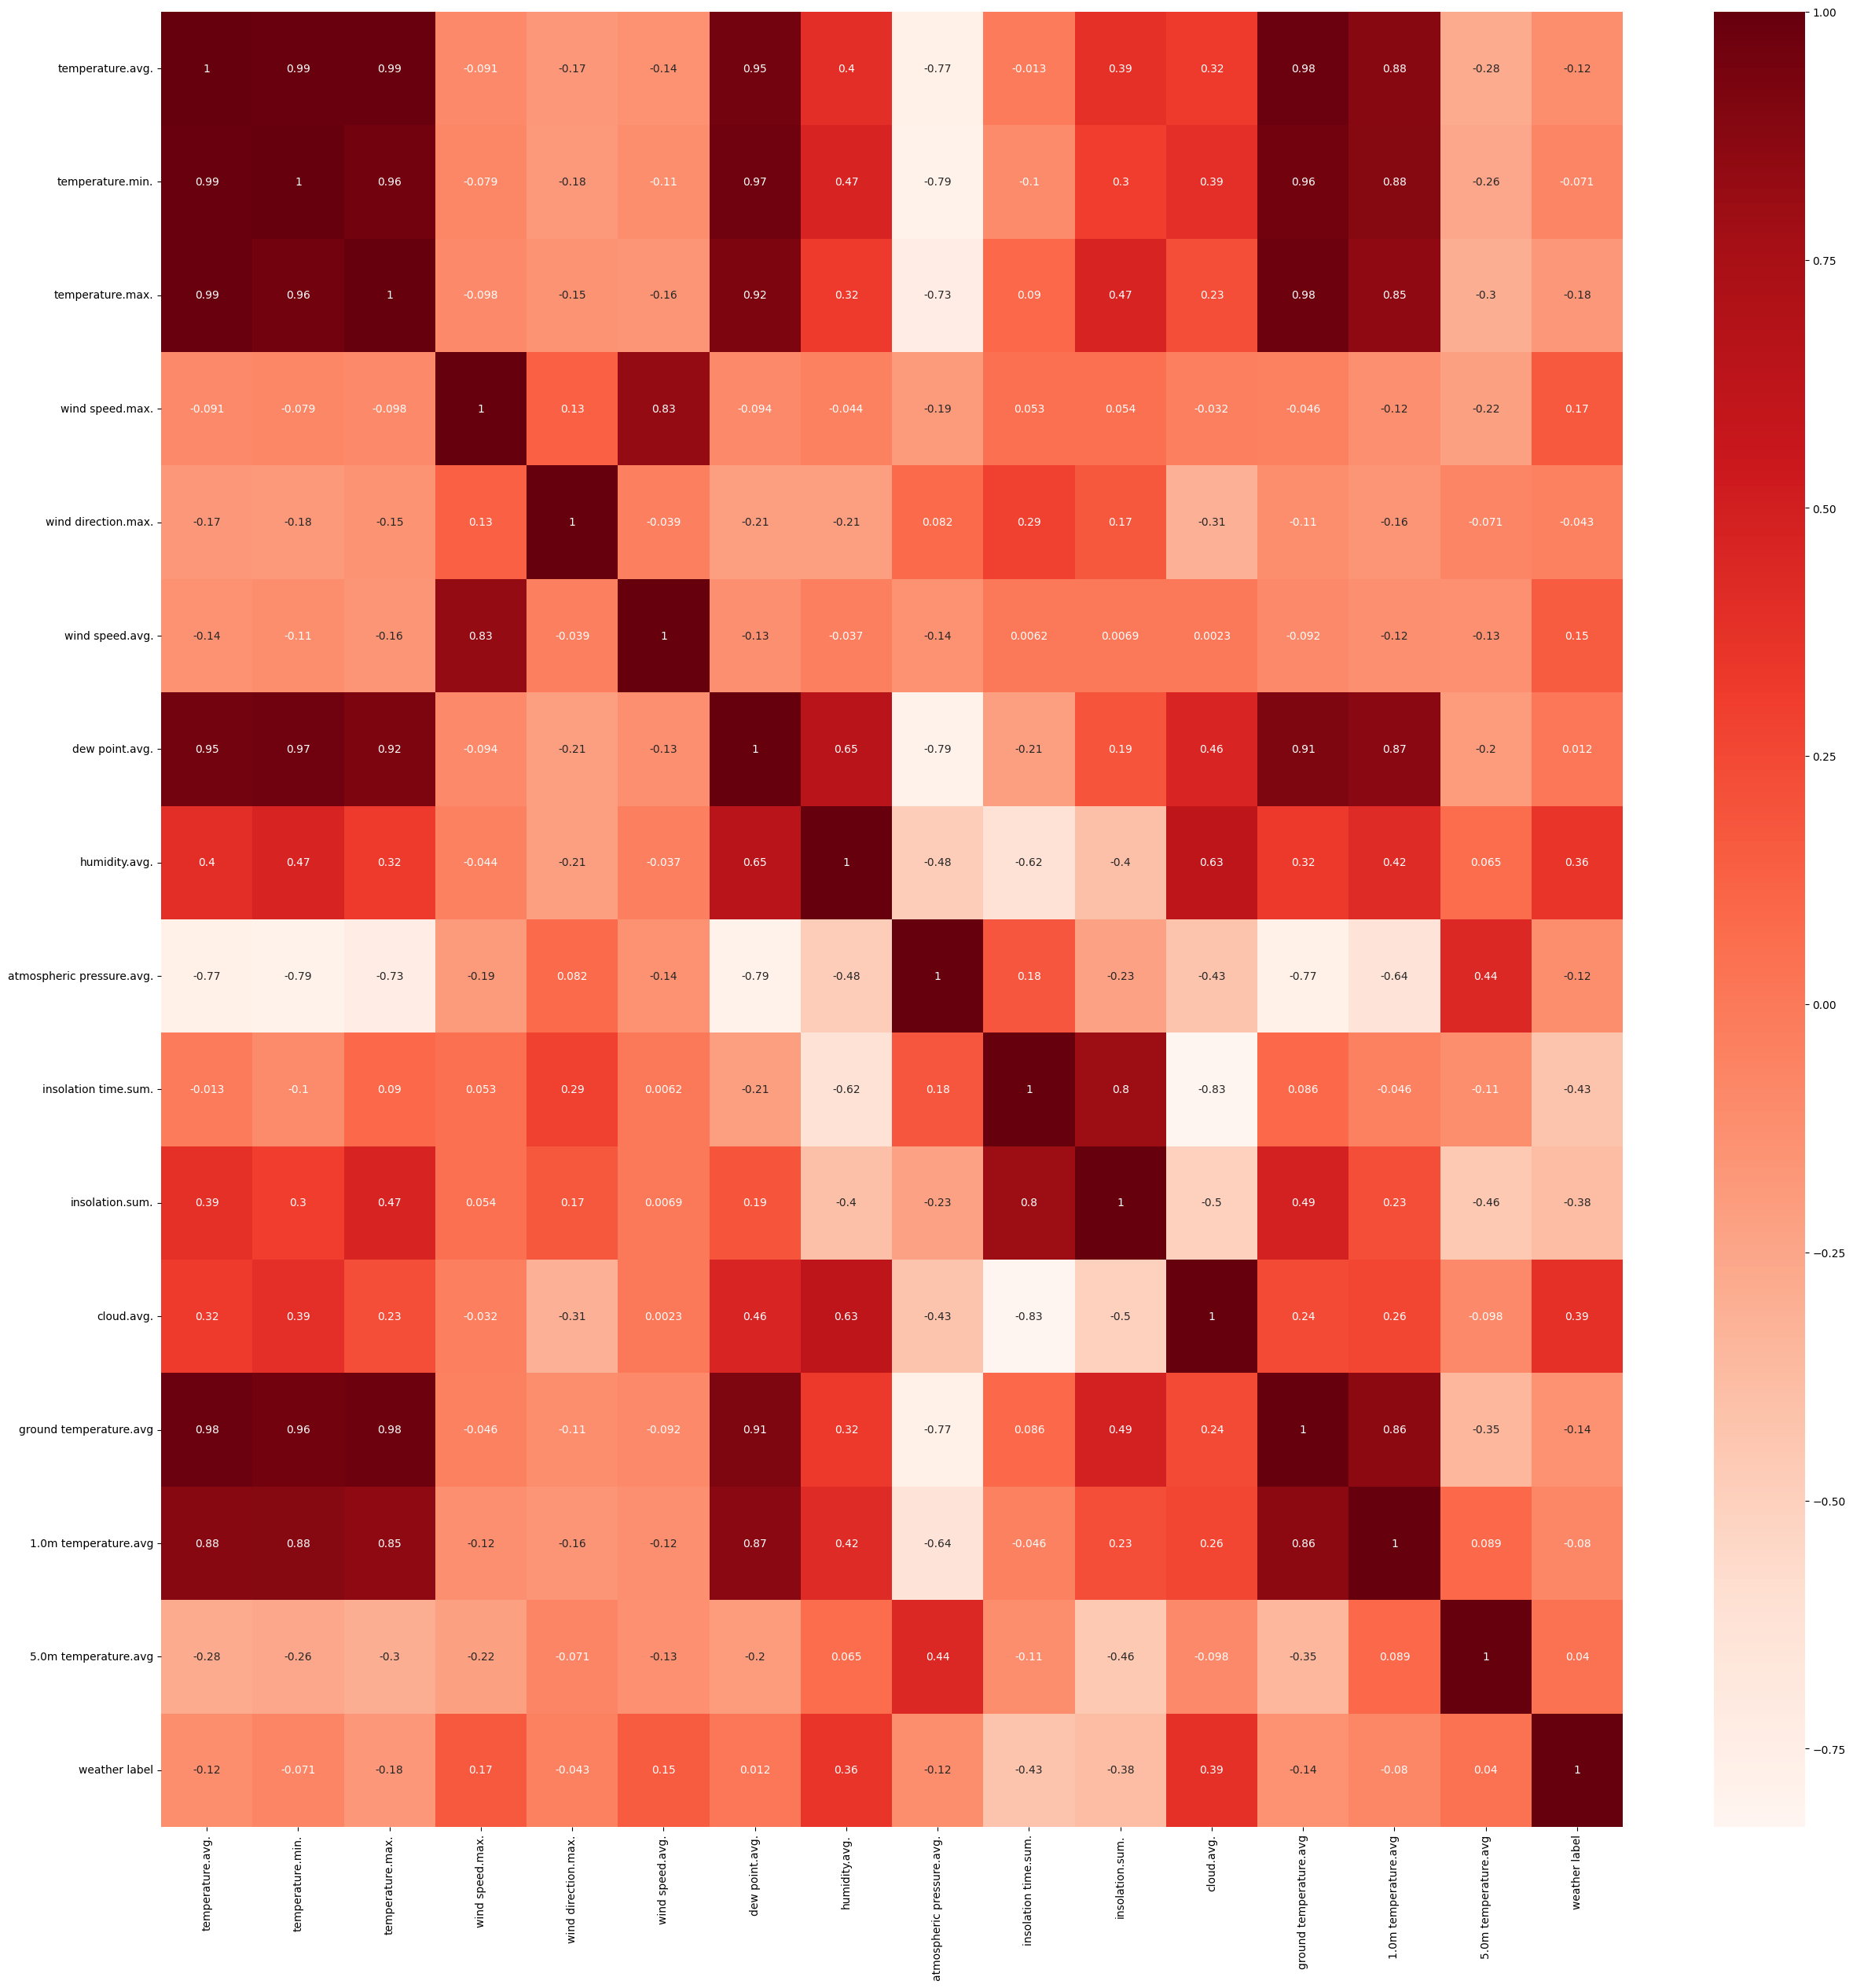

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
cor = train_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cloud avg. , humidity.avg. 와 가장 관련이 높음.

### Backward elimination

In [ ]:
X = sm.add_constant(x)

#모형 학습
model = sm.OLS(y,X).fit()

#예측치 생성
predictions = model.predict(X)

#pvalues 확인
model.pvalues

const                        1.727232e-07
temperature.avg.             3.470388e-04
temperature.min.             1.259876e-02
temperature.max.             4.071630e-05
wind speed.max.              1.106813e-07
wind direction.max.          7.222929e-01
wind speed.avg.              4.680236e-03
dew point.avg.               1.900618e-05
humidity.avg.                9.175143e-11
atmospheric pressure.avg.    3.751872e-10
insolation time.sum.         3.017428e-01
insolation.sum.              4.688105e-01
cloud.avg.                   5.254937e-13
ground temperature.avg       9.182612e-06
1.0m temperature.avg         8.280076e-01
5.0m temperature.avg         3.668395e-03
dtype: float64

< p-value가 0.05 이상인 feature >  

---


1.0m temperature.avg ~ 8.280076e-01

wind direction.max. ~ 7.222929e-01


In [ ]:
#1.0m temperature.avg 제거
X=X.drop(['1.0m temperature.avg'],axis=1)
model=sm.OLS(y, X).fit()
model.pvalues

const                        1.582452e-07
temperature.avg.             3.381310e-04
temperature.min.             1.191974e-02
temperature.max.             3.982327e-05
wind speed.max.              1.110961e-07
wind direction.max.          7.190078e-01
wind speed.avg.              4.701037e-03
dew point.avg.               1.620244e-05
humidity.avg.                6.452362e-11
atmospheric pressure.avg.    2.936349e-10
insolation time.sum.         3.082630e-01
insolation.sum.              4.650923e-01
cloud.avg.                   2.677282e-13
ground temperature.avg       8.387812e-07
5.0m temperature.avg         5.957160e-05
dtype: float64

In [ ]:
#wind direction.max. 제거
X=X.drop(['wind direction.max.'],axis=1)
model=sm.OLS(y, X).fit()
model.pvalues

const                        9.467170e-08
temperature.avg.             3.610251e-04
temperature.min.             1.267763e-02
temperature.max.             3.831755e-05
wind speed.max.              1.697263e-08
wind speed.avg.              1.795994e-03
dew point.avg.               1.639671e-05
humidity.avg.                6.553613e-11
atmospheric pressure.avg.    1.667970e-10
insolation time.sum.         3.228396e-01
insolation.sum.              4.698891e-01
cloud.avg.                   2.818383e-13
ground temperature.avg       4.906732e-07
5.0m temperature.avg         5.986128e-05
dtype: float64

## Data Preprocessing

In [ ]:
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

Min : 0.0, Max : 10.0


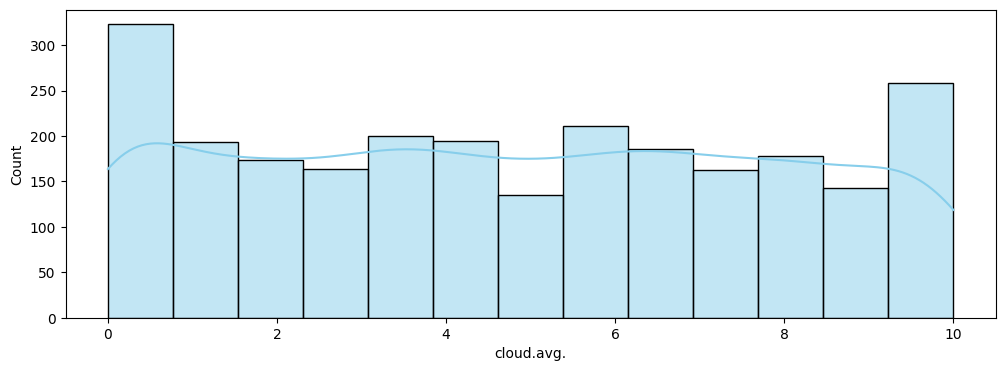

In [ ]:
# cloud 분포 확인
print(f'Min : {train_data["cloud.avg."].min()}, Max : {train_data["cloud.avg."].max()}')

plt.figure(figsize=(12, 4))

data = train_data['cloud.avg.']

sns.histplot(data, color='skyblue', kde=True)
plt.xlabel('cloud.avg.')
plt.show()

In [ ]:
# cloud.avg.가 특정 값보다 작은 경우의 데이터 필터링
filtered_data = train_data[train_data['cloud.avg.'] < 1.5]

# weather label 값의 빈도수 계산 및 상위 5개의 값 추출
top_5_weather_labels = filtered_data['weather label'].value_counts().head(5)

print(top_5_weather_labels)


weather label
0.0    470
1.0     19
4.0      5
Name: count, dtype: int64


In [ ]:
# cloud.avg.가 4보다 작은 경우 weather label 평균
train_data[train_data['cloud.avg.'] < 10].groupby('cloud.avg.')['weather label'].mean().reset_index().T

0         1         2     3         4         5         6   \
cloud.avg.     0.0  0.100000  0.300000  0.40  0.500000  0.600000  0.800000   
weather label  0.0  0.105263  0.028571  0.16  0.034483  0.153846  0.047619   

                     7         8         9         10        11        12  \
cloud.avg.     0.900000  1.000000  1.100000  1.300000  1.400000  1.500000   
weather label  0.185185  0.085714  0.045455  0.242424  0.212121  0.545455   

                     13        14        15        16      17    18      19  \
cloud.avg.     1.600000  1.800000  1.900000  2.000000  2.1000  2.30  2.4000   
weather label  0.275862  0.321429  0.266667  0.066667  0.1875  0.52  0.1875   

                20      21    22        23        24        25        26  \
cloud.avg.     2.5  2.6000  2.80  2.900000  3.000000  3.100000  3.300000   
weather label  0.5  0.3125  0.45  0.086957  0.307692  0.212121  0.366667   

                     27        28        29        30   31        32   33  \
cloud.avg.     3.400000  3.500000  3.600000  3.800000  3.9  4.000000  4.1   
weather label  0.216216  0.194444  0.454545  0.380952  0.3  0.363636  0.8   

                     34   35        36        37        38        39  \
cloud.avg.     4.300000  4.4  4.500000  4.600000  4.800000  4.900000   
weather label  0.772727  0.4  0.486486  0.208333  0.818182  0.304348   

                     40        41    42      43        44        45   46   47  \
cloud.avg.     5.000000  5.100000  5.30  5.4000  5.500000  5.600000  5.8  5.9   
weather label  0.708333  0.433333  0.48  0.5625  0.888889  0.259259  0.8  0.5   

                     48        49   50        51        52        53  \
cloud.avg.     6.000000  6.100000  6.3  6.400000  6.500000  6.600000   
weather label  0.481481  0.512821  0.5  0.565217  0.857143  0.837838   

                     54        55        56        57        58        59  \
cloud.avg.     6.800000  6.900000  7.000000  7.100000  7.300000  7.400000   
weather label  0.575758  0.548387  0.724138  0.652174  0.833333  0.878788   

                     60   61        62        63        64        65  \
cloud.avg.     7.500000  7.6  7.800000  7.900000  8.000000  8.100000   
weather label  0.896552  0.8  0.772727  0.636364  0.733333  0.861111   

                     66        67        68   69        70        71    72  \
cloud.avg.     8.300000  8.400000  8.500000  8.6  8.800000  8.900000  9.00   
weather label  0.935484  0.923077  0.774194  0.8  0.842105  1.064516  0.92   

                     73        74        75        76        77        78  \
cloud.avg.     9.100000  9.300000  9.400000  9.500000  9.600000  9.800000   
weather label  1.058824  1.178571  1.096774  1.028571  1.034483  1.052632   

                     79  
cloud.avg.     9.900000  
weather label  1.115385

Min : 17.9, Max : 99.3


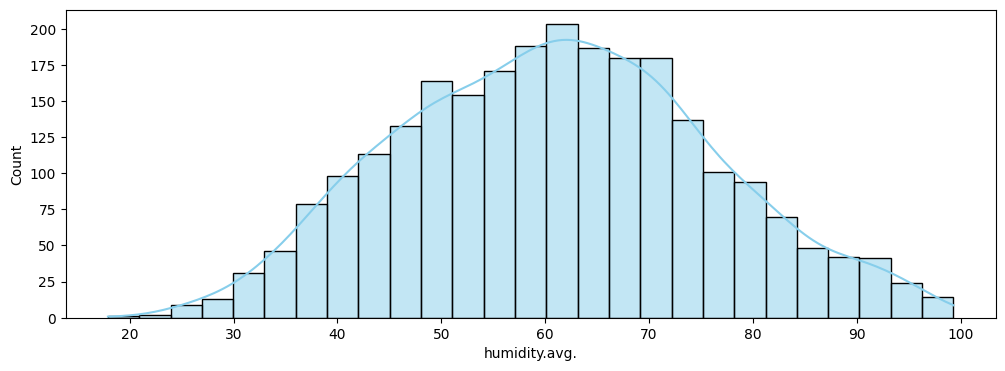

In [ ]:
# humidity.avg. 분포 확인
print(f'Min : {train_data["humidity.avg."].min()}, Max : {train_data["humidity.avg."].max()}')

plt.figure(figsize=(12, 4))

data = train_data['humidity.avg.']

sns.histplot(data, color='skyblue', kde=True)
plt.xlabel('humidity.avg.')
plt.show()

In [ ]:
 #humidity.avg.가 30보다 작은 경우 weather label 평균
train_data[train_data['humidity.avg.'] < 30].groupby('humidity.avg.')['weather label'].mean().reset_index().T

0     1     2     3     4     5     6     7     8     9   \
humidity.avg.  17.9  22.9  23.8  24.3  25.6  25.8  26.0  26.1  26.4  26.6   
weather label   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                 10    11    12    13    14    15    16    17    18    19  
humidity.avg.  27.0  27.1  27.4  27.5  28.3  28.5  28.8  29.0  29.3  29.5  
weather label   0.0   0.5   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0

## Preprocessing - scaling

In [ ]:
# Target Encoding
object_columns = train.select_dtypes(include='object').columns

for i in object_columns:
    le = TargetEncoder()
    train[i] = le.fit_transform(train[i], train['weather label'])
    test[i] = le.transform(test[i])

In [ ]:

# RobustScaler 적용 -> 이유 : standardscaler에 비해 outlier에 덜 민감함
robustScaler = RobustScaler()
print(robustScaler.fit(train))

train = robustScaler.fit_transform(train)
test_data = robustScaler.fit_transform(test)


RobustScaler()


In [ ]:
param_grid = {
    'num_leaves': range(20, 70),
    'max_depth': [5, 10, 15, 20, 25, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2 , 0.3],
    'n_estimators': [50, 100, 150, 200, 250],
    'min_child_samples': [20, 30, 40, 50],
    'subsample': [0.3, 0.5, 0.7, 1.0],
    'colsample_bytree': [0.1, 0.2, 0.3],
    'reg_alpha': [ 0.5, 1.0, 1.5 ,2.0, 2.5],
    'reg_lambda': [1, 5 , 10 , 15]
}


In [ ]:
from sklearn.metrics import f1_score

In [ ]:

def skf_train_model(train, param_grid, n_iter_search=10):
    X = train.copy()
    y = X.pop('weather label')  # 예측할 레이블 분리


    test_predictions = np.zeros(len(X))  # pred을 누적할 배열
    val_scores = []  # 각 fold에서의 검증 세트에 대한 평가 성능을 저장할 리스트

    # 특정 열 삭제 ~ 피어슨 상관계수에서 0.05이상인 열
    dp1 = '1.0m temperature.avg'  # 삭제할 열의 이름1
    X.drop(columns=[dp1], inplace=True)
    dp2 = 'wind direction.max.'  # 삭제할 열의 이름2
    X.drop(columns=[dp2], inplace=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # RandomizedSearchCV를 사용하여 최적의 매개변수 찾기
    random_search = RandomizedSearchCV(estimator=LGBMClassifier(), param_distributions=param_grid, n_iter=n_iter_search,
                                       scoring='accuracy', cv=skf, random_state=42, verbose=1)
    random_search.fit(X, y)

    print("Best Parameters found by Randomized Search:")
    print(random_search.best_params_)
    print()

    best_estimator = random_search.best_estimator_

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        model = clone(best_estimator)  # 최적의 estimator로 모델 복제

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)

        valid_y_pred = model.predict(X_valid)

        acc = accuracy_score(y_valid, valid_y_pred)
        f1 = f1_score(y_valid, valid_y_pred, average='weighted')
        score = acc + 2 * f1

        print(f"Fold {fold}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, Combined Score = {score:.4f}")
        print("-" * 50)

        val_scores.append(score)

    print("Best Parameters found by Randomized Search:")
    print(random_search.best_params_)
    print(f"\n Mean Combined Score: {np.mean(val_scores):.4f}")

    return val_scores, random_search.best_params_


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier


# skf_train_model 함수 호출
val_scores, best_params = skf_train_model(train_data, param_grid, n_iter_search=20)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 


Best Parameters found by Randomized Search: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1.5, 'num_leaves': 29, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.3}


In [ ]:
best_params.update({"random_state": 293, "verbosity": -1})

lgbm = LGBMClassifier(**best_params)

## Final model train & Pred & Save



In [ ]:
test

temperature.avg.  temperature.min.  temperature.max.  wind speed.max.  \
0                 12.6               7.0              18.4              6.6   
1                 22.3              19.9              26.3              5.7   
2                 31.7              28.3              38.0              5.8   
3                 -5.1              -7.0              -1.3              7.2   
4                 26.7              24.1              30.0              4.3   
5                 26.5              24.1              29.2              7.3   
6                  9.9               6.9              15.1              3.6   
7                 15.5               9.0              22.5              4.2   
8                  1.0              -0.7               3.8              4.0   
9                  9.9               5.6              15.3              5.7   
10                 0.4              -3.8               5.9              5.9   
11                13.3              10.6              17.8              6.3   
12                29.1              26.4              32.9              3.5   
13                21.2              18.6              24.6              3.9   
14                12.4               8.4              18.6              3.6   
15                -0.6              -5.3               6.4              3.7   
16                 4.9               3.1               8.1              2.8   
17                 3.7              -2.5              10.1              3.6   
18                 9.4               5.0              14.2              4.4   
19                24.1              22.0              28.0              3.8   
20                28.1              24.7              32.0              3.4   
21                 6.7               4.2              11.4              3.1   
22                28.9              24.6              33.6              5.3   
23                 5.5               3.7               9.6              9.4   
24                26.7              23.3              31.0              4.9   
25                -0.6              -7.6               6.9              3.2   
26                24.8              19.9              30.8              4.0   
27                30.4              26.4              35.9              4.1   
28                28.2              25.5              31.0              5.0   
29                21.3              18.4              25.8              5.5   
30                25.4              20.0              32.8              4.5   
31                 1.9              -1.2               6.0              5.9   
32                24.2              20.4              29.8              3.4   
33                14.0              10.4              16.1              6.7   
34                11.1               5.6              17.0              5.7   
35                15.6              11.7              18.5              3.5   
36                21.9              20.4              23.7              3.3   
37                12.2               9.9              14.7              5.4   
38                11.3               8.1              14.8              5.7   
39                 6.1               1.3              12.5              4.4   
40                12.1               7.6              17.1              3.7   
41                26.8              25.4              28.1              6.0   
42                23.9              20.8              28.4              6.0   
43                -5.3              -7.7              -2.7              4.7   
44               -12.2             -16.6              -7.5              6.5   
45                20.6              15.1              25.1              5.2   
46                22.2              19.3              26.2              6.3   
47                 4.1              -2.7              10.5              4.2   
48                 2.5              -2.5               8.0              4.2   
49                 6.5               0.0              12

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/DA_contest/Submission_example.csv')

In [ ]:
submission

0
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
90    0
91    0
92    0
93    0
94    0
95    0
96    0
97    0
98    0
99    0
100   0
101   0
102   0
103   0
104   0
105   0
106   0
107   0
108   0
109   0
110   0
111   0
112   0
113   0
114   0
115   0
116   0
117   0
118   0
119   0
120   0
121   0
122   0
123   0
124   0
125   0
126   0
127   0
128   0
129   0
130   0
131   0
132   0
133   0
134   0
135   0
136   0
137   0
138   0
139   0
140   0
141   0
142   0
143   0
144   0
145   0
146   0
147   0
148   0
149   0
150   0
151   0
152   0
153   0
154   0
155   0
156   0
157   0
158   0
159   0
160   0
161   0
162   0
163   0
164   0
165   0
166   0
167   0
168   0
169   0
170   0
171   0
172   0
173   0
174   0
175   0
176   0
177   0
178   0
179   0
180   0
181   0
182   0
183   0
184   0
185   0
186   0
187   0
188   0
189   0
190   0
191   0
192   0
193   0
194   0
195   0
196   0
197   0
198   0
199   0
200   0
201   0
202   0
203   0
204   0
205   0
206   0
207   0
208   0
209   0
210   0
211   0
212   0
213   0
214   0
215   0
216   0
217   0
218   0
219   0
220   0
221   0
222   0
223   0
224   0
225   0
226   0
227   0
228   0
229   0
230   0
231   0
232   0
233   0
234   0
235   0
236   0
237   0
238   0
239   0
240   0
241   0
242   0
243   0
244   0
245   0
246   0
247   0
248   0
249   0
250   0
251   0
252   0
253   0
254   0
255   0
256   0
257   0
258   0
259   0
260   0
261   0
262   0
263   0
264   0
265   0
266   0
267   0
268   0
269   0
270   0
271   0
272   0
273   0
274   0
275   0
276   0
277   0
278   0
279   0
280   0
281   0
282   0
283   0
284   0
285   0
286   0
287   0
288   0
289   0
290   0
291   0
292   0
293   0
294   0
295   0
296   0
297   0
298   0
299   0
300   0
301   0
302   0
303   0
304   0
305   0
306   0
307   0
308   0
309   0
310   0
311   0
312   0
313   0
314   0
315   0
316   0
317   0
318   0
319   0
320   0
321   0
322   0
323   0
324   0
325   0
326   0
327   0
328   0
329   0
330   0
331   0
332   0
333   0
334   0
335   0
336   0
337   0
338   0
339   0
340   0
341   0
342   0
343   0
344   0
345   0
346   0
347   0
348   0
349   0
350   0
351   0
352   0
353   0
354   0
355   0
356   0
357   0
358   0
359   0
360   0
361   0
362   0
363   0
364   0
365   0
366   0
367   0
368   0
369   0
370   0
371   0
372   0
373   0
374   0
375   0
376   0
377   0
378   0
379   0
380   0
381   0
382   0
383   0
384   0
385   0
386   0
387   0
388   0
389   0
390   0
391   0
392   0
393   0
394   0
395   0
396   0
397   0
398   0
399   0
400   0
401   0
402   0
403   0
404   0
405   0
406   0
407   0
408   0
409   0
410   0
411   0
412   0
413   0
414   0
415   0
416   0
417   0
418   0
419   0
420   0
421   0
422   0
423   0
424   0
425   0
426   0
427   0
428   0
429   0
430   0
431   0
432   0
433   0
434   0
435   0
436   0
437   0
438   0
439   0
440   0
441   0
442   0
443   0
444   0
445   0
446   0
447   0
448   0
449   0
450   0
451   0
452   0
453   0
454   0
455   0
456   0
457   0
458   0
459   0
460   0
461   0
462   0
463   0
464   0
465   0
466   0
467   0
468   0
469   0
470   0
471   0
472   0
473   0
474   0
475   0
476   0
477   0
478   0
479   0
480   0
481   0
482   0
483   0
484   0
485   0
486   0
487   0
488   0
489   0
490   0
491   0
492   0
493   0
494   0
495   0
496   0
497   0
498   0
499   

In [ ]:
# 최종 모델 학습 및 평가
X_train = train_data.drop(columns=['weather label'])
y_train = train_data['weather label']
lgbm.fit(X_train, y_train)


LGBMClassifier(colsample_bytree=0.3, learning_rate=0.05, max_depth=20,
               min_child_samples=40, num_leaves=29, random_state=293,
               reg_alpha=1.5, reg_lambda=5, verbosity=-1)

In [ ]:
test_pred = lgbm.predict(test)

In [ ]:
print("Test Pred : ")
np.set_printoptions(threshold=np.inf)

print(test_pred)

Test Pred : 
[0. 1. 0. 4. 0. 1. 0. 0. 1. 0. 4. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 4. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 4. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 4. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 4. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 4. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1

In [ ]:
submission.rename(columns={'0': 'pred'}, inplace=True)
submission

pred
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0
91       0
92       0
93       0
94       0
95       0
96       0
97       0
98       0
99       0
100      0
101      0
102      0
103      0
104      0
105      0
106      0
107      0
108      0
109      0
110      0
111      0
112      0
113      0
114      0
115      0
116      0
117      0
118      0
119      0
120      0
121      0
122      0
123      0
124      0
125      0
126      0
127      0
128      0
129      0
130      0
131      0
132      0
133      0
134      0
135      0
136      0
137      0
138      0
139      0
140      0
141      0
142      0
143      0
144      0
145      0
146      0
147      0
148      0
149      0
150      0
151      0
152      0
153      0
154      0
155      0
156      0
157      0
158      0
159      0
160      0
161      0
162      0
163      0
164      0
165      0
166      0
167      0
168      0
169      0
170      0
171      0
172      0
173      0
174      0
175      0
176      0
177      0
178      0
179      0
180      0
181      0
182      0
183      0
184      0
185      0
186      0
187      0
188      0
189      0
190      0
191      0
192      0
193      0
194      0
195      0
196      0
197      0
198      0
199      0
200      0
201      0
202      0
203      0
204      0
205      0
206      0
207      0
208      0
209      0
210      0
211      0
212      0
213      0
214      0
215      0
216      0
217      0
218      0
219      0
220      0
221      0
222      0
223      0
224      0
225      0
226      0
227      0
228      0
229      0
230      0
231      0
232      0
233      0
234      0
235      0
236      0
237      0
238      0
239      0
240      0
241      0
242      0
243      0
244      0
245      0
246      0
247      0
248      0
249      0
250      0
251      0
252      0
253      0
254      0
255      0
256      0
257      0
258      0
259      0
260      0
261      0
262      0
263      0
264      0
265      0
266      0
267      0
268      0
269      0
270      0
271      0
272      0
273      0
274      0
275      0
276      0
277      0
278      0
279      0
280      0
281      0
282      0
283      0
284      0
285      0
286      0
287      0
288      0
289      0
290      0
291      0
292      0
293      0
294      0
295      0
296      0
297      0
298      0
299      0
300      0
301      0
302      0
303      0
304      0
305      0
306      0
307      0
308      0
309      0
310      0
311      0
312      0
313      0
314      0
315      0
316      0
317      0
318      0
319      0
320      0
321      0
322      0
323      0
324      0
325      0
326      0
327      0
328      0
329      0
330      0
331      0
332      0
333      0
334      0
335      0
336      0
337      0
338      0
339      0
340      0
341      0
342      0
343      0
344      0
345      0
346      0
347      0
348      0
349      0
350      0
351      0
352      0
353      0
354      0
355      0
356      0
357      0
358      0
359      0
360      0
361      0
362      0
36

In [ ]:
len(test_pred)

1096

In [ ]:
len(submission)

1095

In [ ]:
len(test)

1096

In [ ]:
new_row = {'pred': 0}
submission.loc[len(submission)] = new_row

len(submission)

1097

In [ ]:
submission['pred'] = test_pred

ValueError: Length of values (1096) does not match length of index (1097)

In [ ]:
print(submission['pred'])

0       0.0
1       1.0
2       0.0
3       4.0
4       0.0
5       1.0
6       0.0
7       0.0
8       0.0
9       0.0
10      4.0
11      1.0
12      0.0
13      1.0
14      0.0
15      0.0
16      1.0
17      0.0
18      0.0
19      1.0
20      1.0
21      0.0
22      0.0
23      1.0
24      0.0
25      0.0
26      0.0
27      0.0
28      1.0
29      1.0
30      0.0
31      0.0
32      0.0
33      1.0
34      1.0
35      1.0
36      1.0
37      1.0
38      1.0
39      0.0
40      0.0
41      1.0
42      0.0
43      4.0
44      0.0
45      0.0
46      1.0
47      0.0
48      0.0
49      0.0
50      0.0
51      0.0
52      1.0
53      0.0
54      0.0
55      0.0
56      0.0
57      0.0
58      1.0
59      1.0
60      0.0
61      1.0
62      1.0
63      0.0
64      0.0
65      0.0
66      1.0
67      0.0
68      1.0
69      0.0
70      0.0
71      1.0
72      0.0
73      1.0
74      0.0
75      0.0
76      0.0
77      0.0
78      0.0
79      0.0
80      0.0
81      1.0
82      0.0
83  

In [ ]:
submission.to_csv('submission_202121620.csv', index=False)
